# Differential Gene Expression Analysis
___
Scope: Extract all differentially expressed genes for each age group from all visits and check whether there are consistently expressed genes across all visits

In [ ]:
import pandas as pd

In [64]:
def get_common_genes_across_visits(filtered_dfs: dict, min_visits: int = 2) -> pd.DataFrame:
    """
    Identify genes common across multiple filtered dataframes and add log2FoldChange values for each visit.

    Args:
        filtered_dfs (dict): A dictionary where keys are visit identifiers (e.g., 'bl', 'v02', 'v04', ...)
                             and values are corresponding filtered DataFrames containing DEGs.
        min_visits (int): Minimum number of visits the gene must appear in to be included in the resulting DataFrame.

    Returns:
        pd.DataFrame: A DataFrame with one row per common gene, columns denoting visits with boolean values,
                      and log2FoldChange values for each visit. The log2FoldChange columns are added at the end.
    """
    # Initialize a dictionary to store genes and their corresponding visit presence
    genes_per_visit = {}

    # For each visit, add all genes to the dictionary and mark their presence
    for visit, df in filtered_dfs.items():
        for _, row in df.iterrows():
            gene = row['Gene']
            if gene not in genes_per_visit:
                genes_per_visit[gene] = {'Gene': gene}
                # Initialize all visits to False and log2FoldChange to None
                for v in filtered_dfs.keys():
                    genes_per_visit[gene][v] = False
                    genes_per_visit[gene][f"{v}_log2FC"] = None
            # Mark the current visit as True for the gene and store its log2FoldChange
            genes_per_visit[gene][visit] = True
            genes_per_visit[gene][f"{visit}_log2FC"] = row['log2FoldChange']

    # Convert the dictionary of genes into a DataFrame
    genes_df = pd.DataFrame.from_dict(genes_per_visit.values())

    # Filter to include only genes that are found in at least `min_visits` visits
    genes_df['visit_count'] = genes_df[list(filtered_dfs.keys())].sum(axis=1)
    common_genes_df = genes_df[genes_df['visit_count'] >= min_visits].drop(columns=['visit_count'])

    # Ensure log2FoldChange columns are moved to the end
    log2fc_columns = [f"{v}_log2FC" for v in filtered_dfs.keys()]
    non_log2fc_columns = [col for col in common_genes_df.columns if col not in log2fc_columns]
    common_genes_df = common_genes_df[non_log2fc_columns + log2fc_columns]

    return common_genes_df

In [1]:
deg_data_path = "/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/dge_stratified/"

## Males aged 30-50

### Read the DEG files

In [13]:
deg_males_30_50_bl = pd.read_csv(deg_data_path + "DEGs_stratified_Male_BL_30-50.csv")
deg_males_30_50_v02 = pd.read_csv(deg_data_path + "DEGs_stratified_Male_V02_30-50.csv")
deg_males_30_50_v04 = pd.read_csv(deg_data_path + "DEGs_stratified_Male_V04_30-50.csv")
deg_males_30_50_v06 = pd.read_csv(deg_data_path + "DEGs_stratified_Male_V06_30-50.csv")
deg_males_30_50_v08 = pd.read_csv(deg_data_path + "DEGs_stratified_Male_V08_30-50.csv")

### Apply thresholds of log2FoldChange >= 0.5 and padj <= 0.05

In [39]:
filtered_deg_males_30_50_bl = deg_males_30_50_bl[(deg_males_30_50_bl['log2FoldChange'].abs() >= 0.5) & (deg_males_30_50_bl['padj'] <= 0.05)]
filtered_deg_males_30_50_v02 = deg_males_30_50_v02[(deg_males_30_50_v02['log2FoldChange'].abs() >= 0.5) & (deg_males_30_50_v02['padj'] <= 0.05)]
filtered_deg_males_30_50_v04 = deg_males_30_50_v04[(deg_males_30_50_v04['log2FoldChange'].abs() >= 0.5) & (deg_males_30_50_v04['padj'] <= 0.05)]
filtered_deg_males_30_50_v06 = deg_males_30_50_v06[(deg_males_30_50_v06['log2FoldChange'].abs() >= 0.5) & (deg_males_30_50_v06['padj'] <= 0.05)]
filtered_deg_males_30_50_v08 = deg_males_30_50_v08[(deg_males_30_50_v08['log2FoldChange'].abs() >= 0.5) & (deg_males_30_50_v08['padj'] <= 0.05)]

### Visualize amounts of up- and downregulated genes

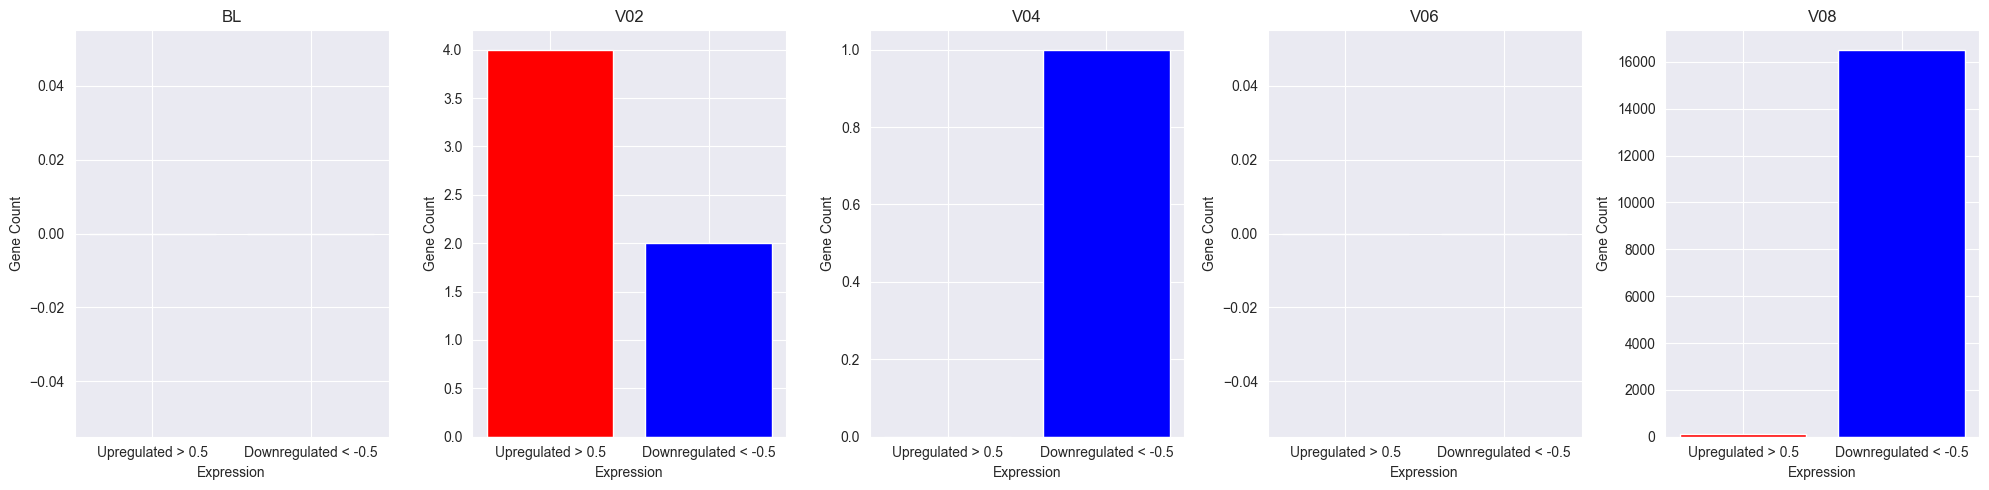

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
dfs = [filtered_deg_males_30_50_bl, filtered_deg_males_30_50_v02, filtered_deg_males_30_50_v04, filtered_deg_males_30_50_v06, filtered_deg_males_30_50_v08]
titles = ["BL", "V02", "V04", "V06", "V08"]

for ax, df, title in zip(axes, dfs, titles):
    count_up = ((df['log2FoldChange'] >= 0.5) & (df['log2FoldChange'] < 10)).sum()
    count_down = ((df['log2FoldChange'] <= -0.5) & (df['log2FoldChange'] > -10)).sum()
    ax.bar(['Upregulated > 0.5', 'Downregulated < -0.5'], [count_up, count_down], color=['red', 'blue'])
    ax.set_title(title)
    ax.set_ylabel('Gene Count')
    ax.set_xlabel('Expression')

plt.tight_layout()
plt.show()

### Visualize amounts of extremely up- and downregulated genes with log2FoldChange values exceeding 10

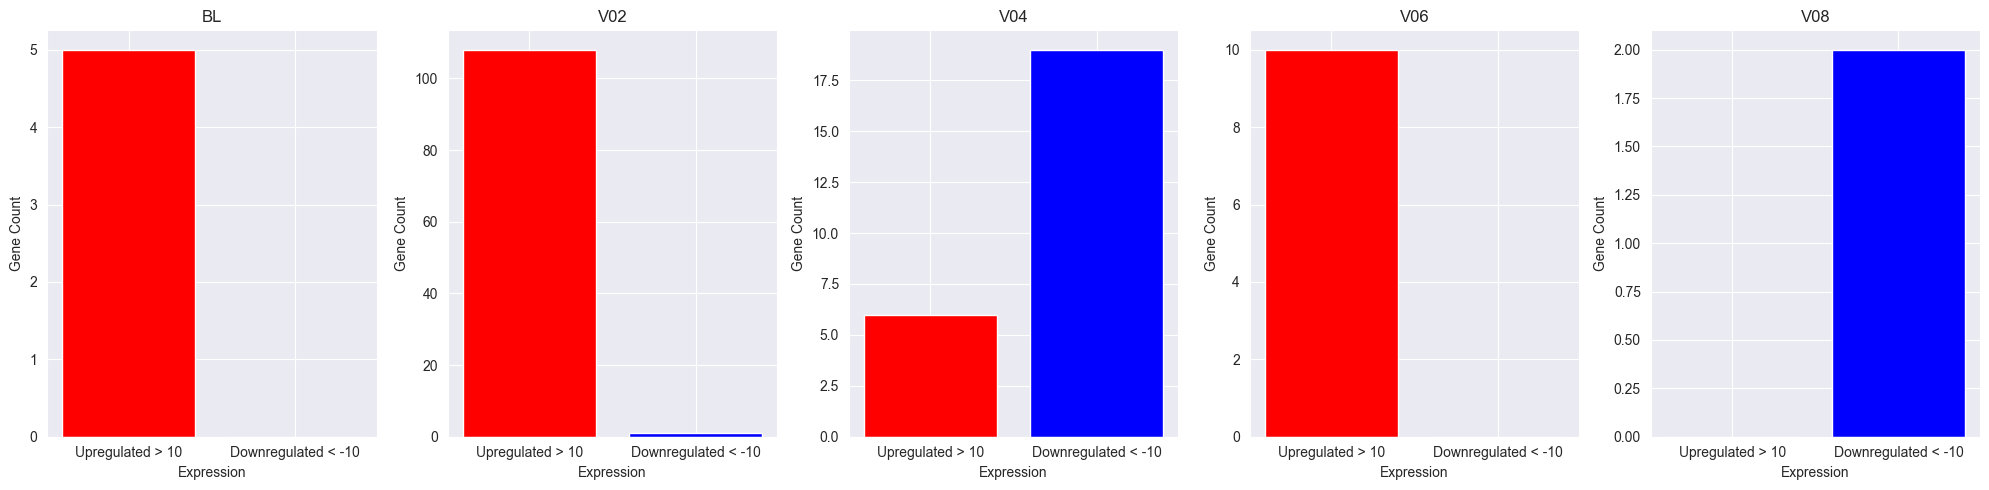

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=False)
dfs = [filtered_deg_males_30_50_bl, filtered_deg_males_30_50_v02, filtered_deg_males_30_50_v04, filtered_deg_males_30_50_v06, filtered_deg_males_30_50_v08]
titles = ["BL", "V02", "V04", "V06", "V08"]

for ax, df, title in zip(axes, dfs, titles):
    count_up = (df['log2FoldChange'] >= 10).sum()
    count_down = (df['log2FoldChange'] <= -10).sum()
    ax.bar(['Upregulated > 10', 'Downregulated < -10'], [count_up, count_down], color=['red', 'blue'])
    ax.set_title(title)
    ax.set_ylabel('Gene Count')
    ax.set_xlabel('Expression')

plt.tight_layout()
plt.show()

### Consistently Appearing DEGs across Visits

In [65]:
filtered_dfs_30_50 = {
    "bl": filtered_deg_males_30_50_bl,
    "v02": filtered_deg_males_30_50_v02,
    "v04": filtered_deg_males_30_50_v04,
    "v06": filtered_deg_males_30_50_v06,
    "v08": filtered_deg_males_30_50_v08
}

common_genes_df_30_50 = get_common_genes_across_visits(filtered_dfs_30_50, min_visits=2)

common_genes_df_30_50

,Gene,bl,v02,v04,v06,v08,bl_log2FC,v02_log2FC,v04_log2FC,v06_log2FC,v08_log2FC
3,ENSG00000276540.1,True,True,True,False,True,17.499452,26.860120,16.560103,NaN,-29.463374
18,ENSG00000252350.1,False,True,False,False,True,NaN,24.614660,NaN,NaN,-5.079729
28,ENSG00000225238.1,False,True,False,False,True,NaN,30.000000,NaN,NaN,-3.620234
57,ENSG00000224653.1,False,True,False,False,True,NaN,22.658956,NaN,NaN,-4.318575
68,ENSG00000236168.1,False,True,False,False,True,NaN,26.718071,NaN,NaN,-3.253442
113,ENSG00000276386.1,False,True,True,False,True,NaN,-1.953539,-2.043980,NaN,-2.831465


### Volcano Plots Males 30-50 all visits

In [24]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.

#### With extreme values

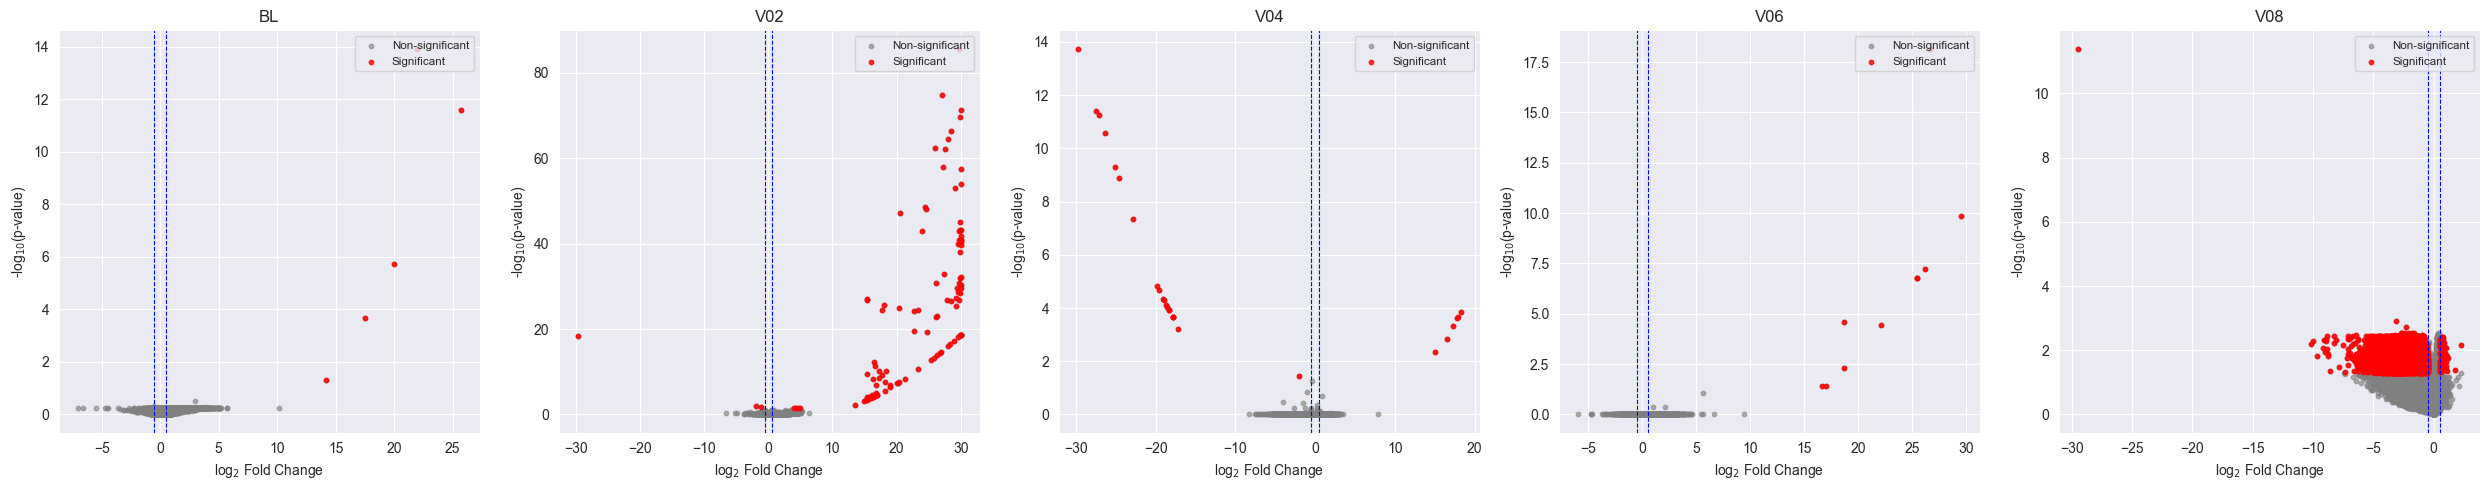

In [34]:
import matplotlib.pyplot as plt
import numpy as np

dfs = [deg_males_30_50_bl, deg_males_30_50_v02, deg_males_30_50_v04, deg_males_30_50_v06, deg_males_30_50_v08]
titles = ['BL', 'V02', 'V04', 'V06', 'V08']

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=False)

for ax, df, title in zip(axes, dfs, titles):
    significant = (df['log2FoldChange'].abs() >= 0.5) & (df['padj'] <= 0.05)
    ax.scatter(df['log2FoldChange'], -np.log10(df['padj']), color='gray', s=10, alpha=0.6, label='Non-significant')
    ax.scatter(df.loc[significant, 'log2FoldChange'],
               -np.log10(df.loc[significant, 'padj']),
               color='red',
               s=10,
               alpha=0.8,
               label='Significant')
    ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=0.8)
    ax.axvline(x=-0.5, color='blue', linestyle='--', linewidth=0.8)
    ax.set_title(title)
    ax.set_xlabel('log$_2$ Fold Change')
    ax.set_ylabel('-log$_{10}$(p-value)')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

#### Without extreme values

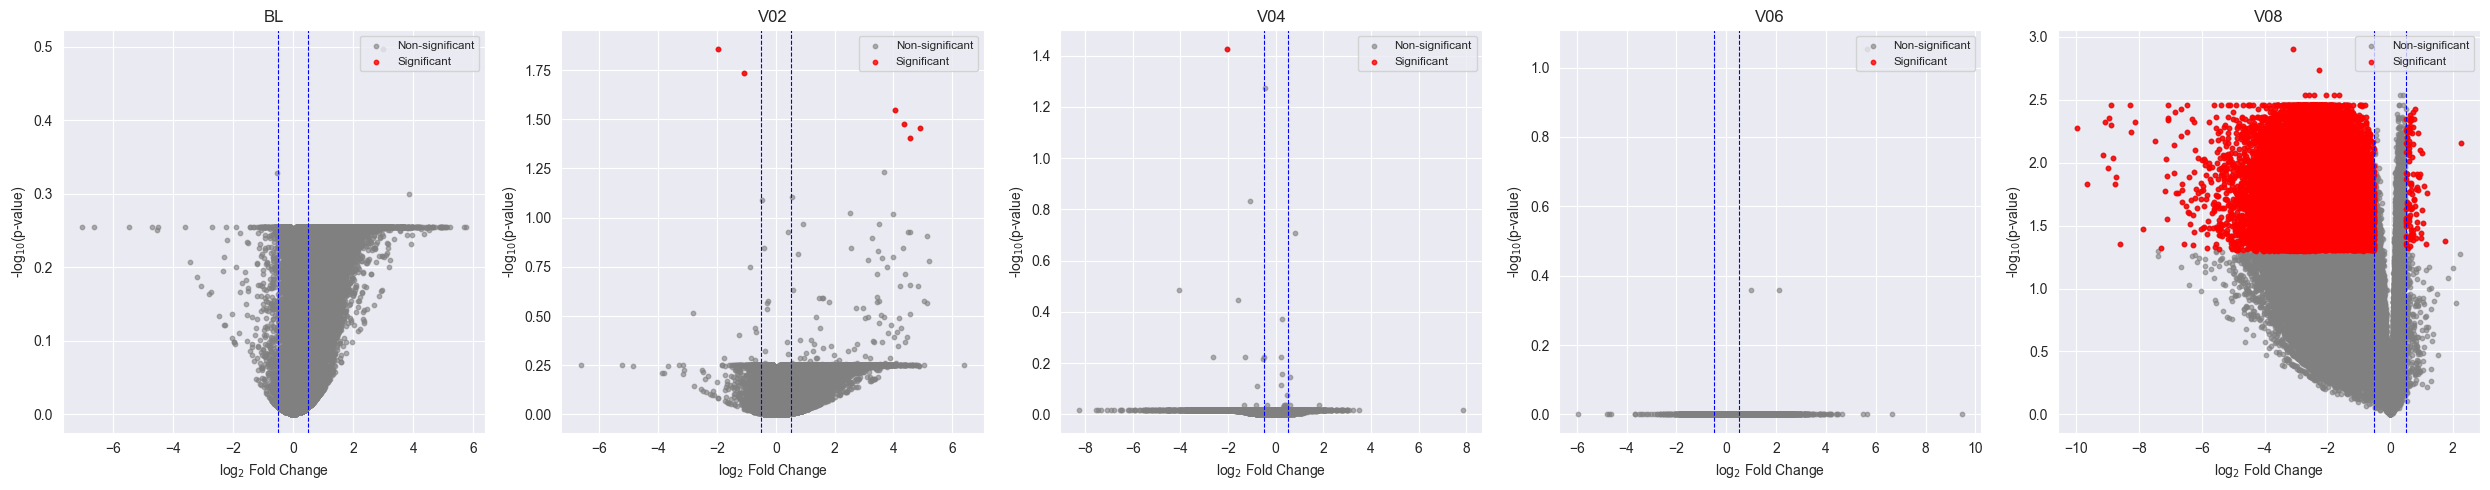

In [33]:
dfs = [deg_males_30_50_bl, deg_males_30_50_v02, deg_males_30_50_v04, deg_males_30_50_v06, deg_males_30_50_v08]
titles = ['BL', 'V02', 'V04', 'V06', 'V08']

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=False)

for ax, df, title in zip(axes, dfs, titles):
    filtered_df = df[(df['log2FoldChange'].abs() <= 10)]
    significant = (filtered_df['log2FoldChange'].abs() >= 0.5) & (filtered_df['padj'] <= 0.05)
    ax.scatter(filtered_df['log2FoldChange'], -np.log10(filtered_df['padj']), color='gray', s=10, alpha=0.6, label='Non-significant')
    ax.scatter(filtered_df.loc[significant, 'log2FoldChange'],
               -np.log10(filtered_df.loc[significant, 'padj']),
               color='red',
               s=10,
               alpha=0.8,
               label='Significant')
    ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=0.8)
    ax.axvline(x=-0.5, color='blue', linestyle='--', linewidth=0.8)
    ax.set_title(title)
    ax.set_xlabel('log$_2$ Fold Change')
    ax.set_ylabel('-log$_{10}$(p-value)')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

___

## Males Aged 50-70

### Read the DEG Files

In [105]:
import pandas as pd
deg_males_50_70_bl = pd.read_csv(deg_data_path + "DEGs_stratified_Male_BL_50-70.csv")
deg_males_50_70_v02 = pd.read_csv(deg_data_path + "DEGs_stratified_Male_V02_50-70.csv")
deg_males_50_70_v04 = pd.read_csv(deg_data_path + "DEGs_stratified_Male_V04_50-70.csv")
deg_males_50_70_v06 = pd.read_csv(deg_data_path + "DEGs_stratified_Male_V06_50-70.csv")
deg_males_50_70_v08 = pd.read_csv(deg_data_path + "DEGs_stratified_Male_V08_50-70.csv")

### Apply thresholds of log2FoldChange >= 0.5 and padj <= 0.05

In [114]:
filtered_deg_males_50_70_bl = deg_males_50_70_bl[(deg_males_50_70_bl['log2FoldChange'].abs() >= 0.5) & (deg_males_50_70_bl['padj'] <= 0.05)]
filtered_deg_males_50_70_v02 = deg_males_50_70_v02[(deg_males_50_70_v02['log2FoldChange'].abs() >= 0.5) & (deg_males_50_70_v02['padj'] <= 0.05)]
filtered_deg_males_50_70_v04 = deg_males_50_70_v04[(deg_males_50_70_v04['log2FoldChange'].abs() >= 0.5) & (deg_males_50_70_v04['padj'] <= 0.05)]
filtered_deg_males_50_70_v06 = deg_males_50_70_v06[(deg_males_50_70_v06['log2FoldChange'].abs() >= 0.5) & (deg_males_50_70_v06['padj'] <= 0.05)]
filtered_deg_males_50_70_v08 = deg_males_50_70_v08[(deg_males_50_70_v08['log2FoldChange'].abs() >= 0.5) & (deg_males_50_70_v08['padj'] <= 0.05)]

### Visualize amounts of up- and downregulated genes


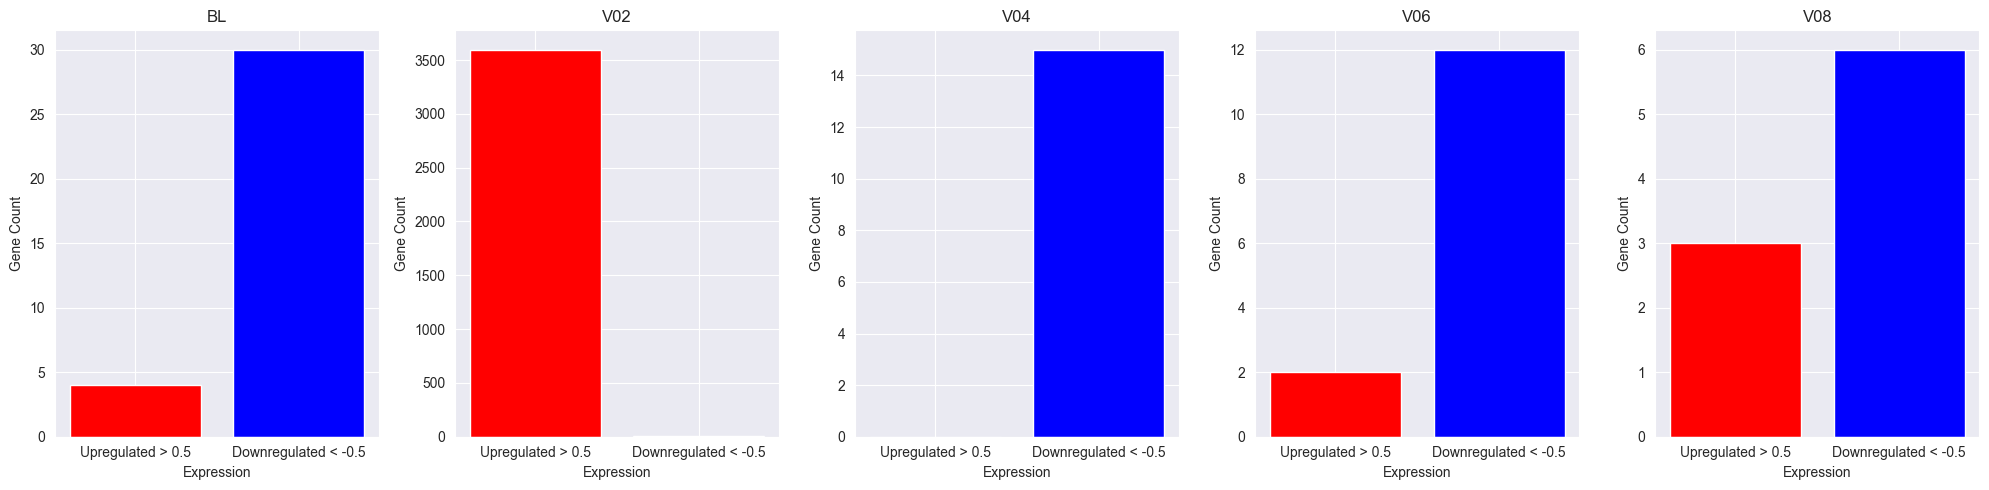

In [115]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=False)
dfs = [filtered_deg_males_50_70_bl, filtered_deg_males_50_70_v02, filtered_deg_males_50_70_v04, filtered_deg_males_50_70_v06, filtered_deg_males_50_70_v08]
titles = ["BL", "V02", "V04", "V06", "V08"]

for ax, df, title in zip(axes, dfs, titles):
    filtered_df = df[(df['padj'] <= 0.05)]
    count_up = ((filtered_df['log2FoldChange'] >= 0.5) & (filtered_df['log2FoldChange'] < 10)).sum()
    count_down = ((filtered_df['log2FoldChange'] <= -0.5) & (filtered_df['log2FoldChange'] > -10)).sum()
    ax.bar(['Upregulated > 0.5', 'Downregulated < -0.5'], [count_up, count_down], color=['red', 'blue'])
    ax.set_title(title)
    ax.set_ylabel('Gene Count')
    ax.set_xlabel('Expression')

plt.tight_layout()
plt.show()

### Visualize amounts of extremely up- and downregulated genes with log2FoldChange values exceeding 10


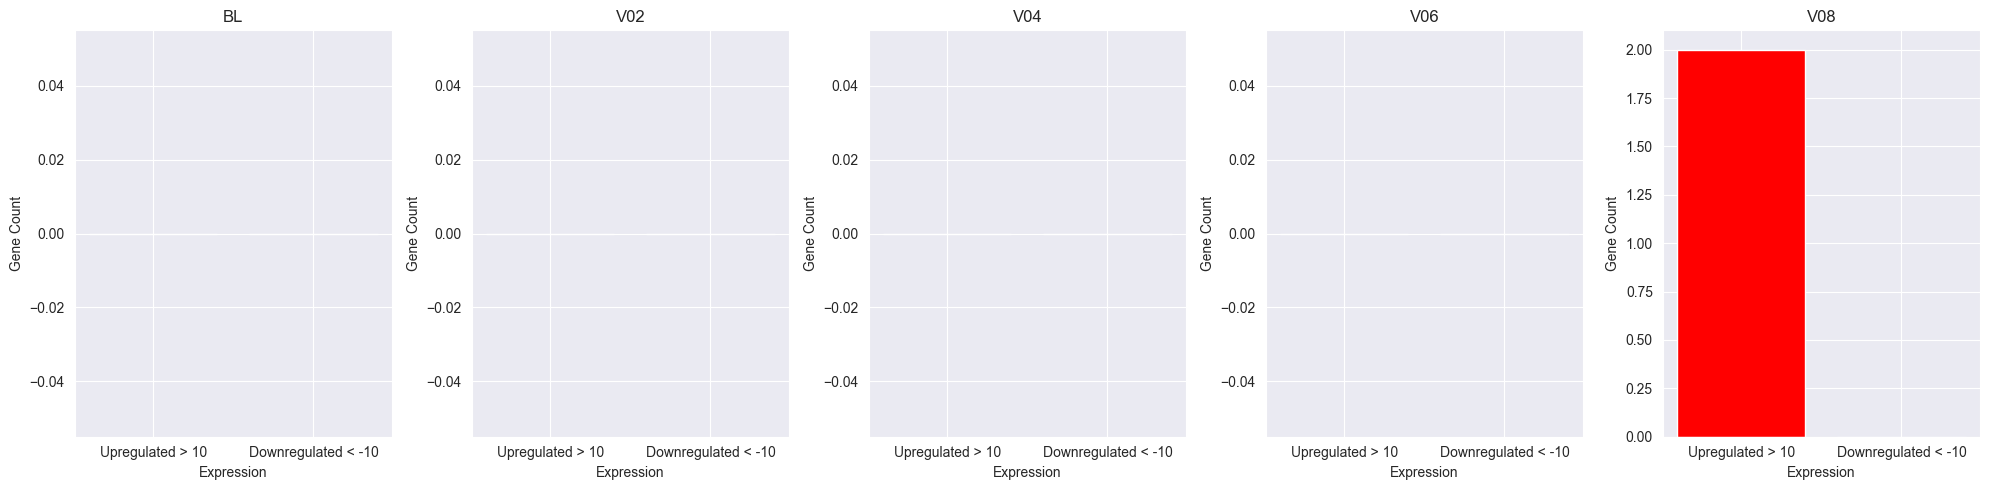

In [116]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=False)
dfs = [filtered_deg_males_50_70_bl, filtered_deg_males_50_70_v02, filtered_deg_males_50_70_v04, filtered_deg_males_50_70_v06, filtered_deg_males_50_70_v08]
titles = ["BL", "V02", "V04", "V06", "V08"]

for ax, df, title in zip(axes, dfs, titles):
    filtered_df = df[(df['padj'] <= 0.05) & (~df['padj'].isna())]
    count_up = (filtered_df['log2FoldChange'] >= 10).sum()
    count_down = (filtered_df['log2FoldChange'] <= -10).sum()
    ax.bar(['Upregulated > 10', 'Downregulated < -10'], [count_up, count_down], color=['red', 'blue'])
    ax.set_title(title)
    ax.set_ylabel('Gene Count')
    ax.set_xlabel('Expression')

plt.tight_layout()
plt.show()

### Consistently Appearing DEGs across Visits


In [117]:
filtered_dfs_50_70 = {
    "bl": filtered_deg_males_50_70_bl,
    "v02": filtered_deg_males_50_70_v02,
    "v04": filtered_deg_males_50_70_v04,
    "v06": filtered_deg_males_50_70_v06,
    "v08": filtered_deg_males_50_70_v08
}

common_genes_df_50_70 = get_common_genes_across_visits(filtered_dfs_50_70, min_visits=2)

common_genes_df_50_70

,Gene,bl,v02,v04,v06,v08,bl_log2FC,v02_log2FC,v04_log2FC,v06_log2FC,v08_log2FC
0,ENSG00000229807.11,True,False,False,True,False,-2.958401,NaN,NaN,-2.371949,NaN
1,ENSG00000185640.5,True,False,False,False,True,-1.456439,NaN,NaN,NaN,-1.750941
4,ENSG00000239710.3,True,True,False,False,False,-1.998197,1.270067,NaN,NaN,NaN
8,ENSG00000207110.1,True,False,False,False,True,-0.753683,NaN,NaN,NaN,-1.582467
11,ENSG00000228549.3,True,False,False,True,False,2.358082,NaN,NaN,2.327700,NaN
14,ENSG00000281741.2,True,True,False,False,True,0.654404,0.803329,NaN,NaN,0.912964
15,ENSG00000227674.2,True,True,False,False,False,1.961992,1.676997,NaN,NaN,NaN
16,ENSG00000273730.1,True,False,False,False,True,-2.425040,NaN,NaN,NaN,-5.188543
21,ENSG00000188536.13,True,False,False,False,True,-0.609555,NaN,NaN,NaN,-3.124813
621,ENSG00000154262.12,False,True,False,True,False,NaN,0.749225,NaN,0.793035,NaN


### Volcano Plots Males 50-70 all visits

#### With extreme values

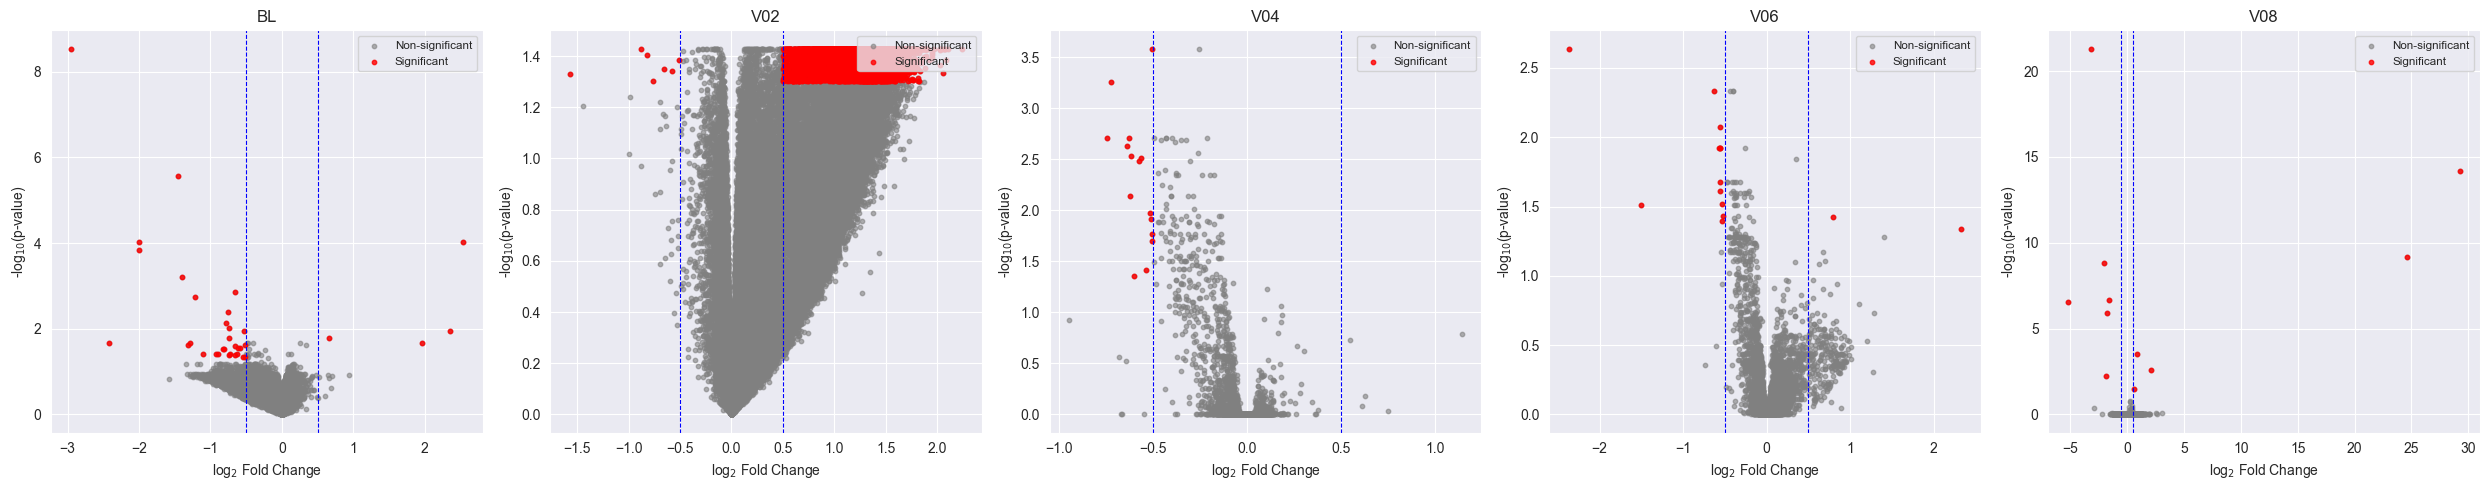

In [118]:
import matplotlib.pyplot as plt
import numpy as np

dfs = [deg_males_50_70_bl, deg_males_50_70_v02, deg_males_50_70_v04, deg_males_50_70_v06, deg_males_50_70_v08]
titles = ['BL', 'V02', 'V04', 'V06', 'V08']

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=False)

for ax, df, title in zip(axes, dfs, titles):
    significant = (df['log2FoldChange'].abs() >= 0.5) & (df['padj'] <= 0.05)
    ax.scatter(df['log2FoldChange'], -np.log10(df['padj']), color='gray', s=10, alpha=0.6, label='Non-significant')
    ax.scatter(df.loc[significant, 'log2FoldChange'],
               -np.log10(df.loc[significant, 'padj']),
               color='red',
               s=10,
               alpha=0.8,
               label='Significant')
    ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=0.8)
    ax.axvline(x=-0.5, color='blue', linestyle='--', linewidth=0.8)
    ax.set_title(title)
    ax.set_xlabel('log$_2$ Fold Change')
    ax.set_ylabel('-log$_{10}$(p-value)')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

#### Without extreme values

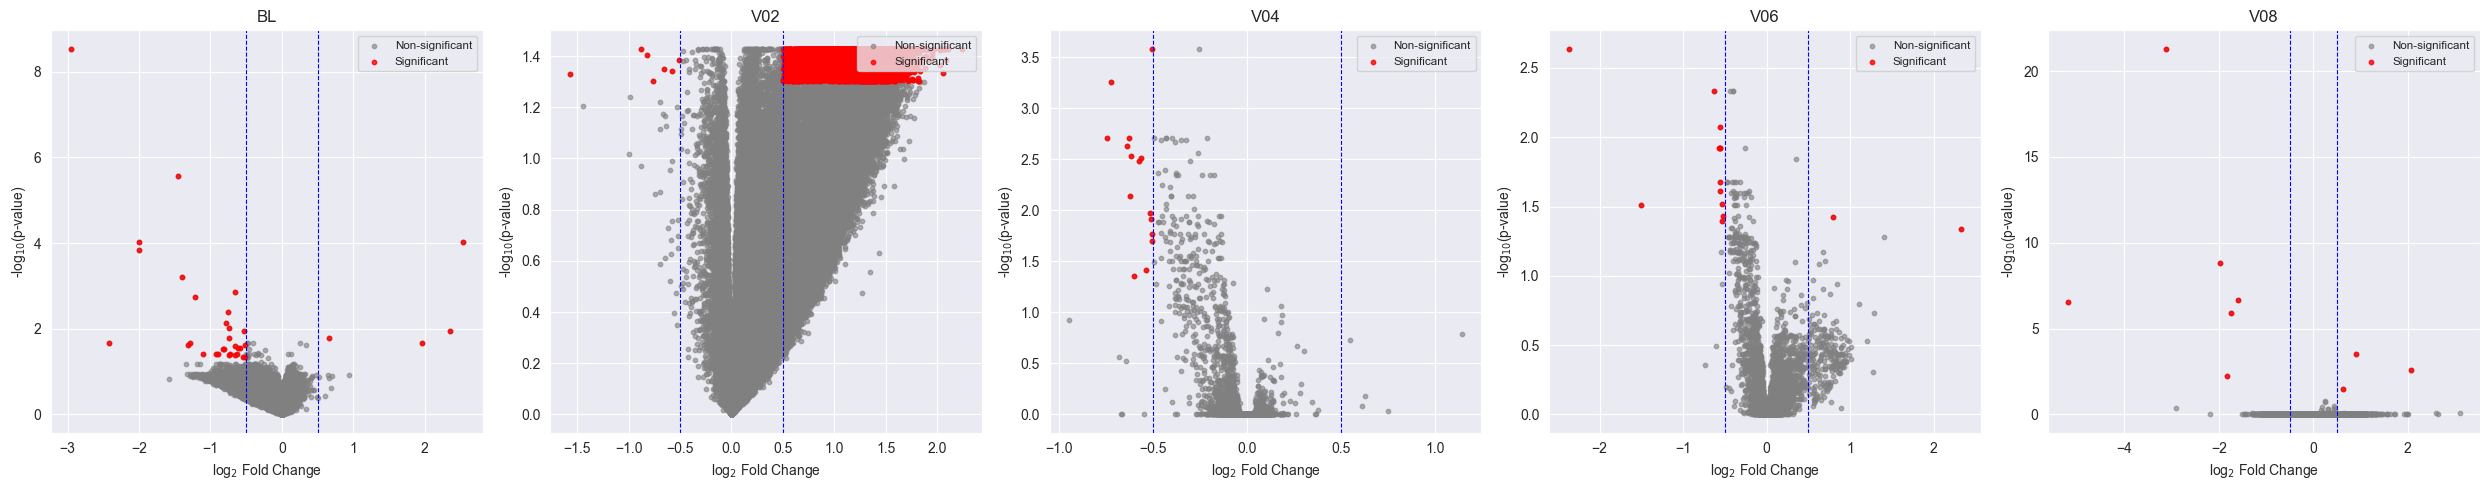

In [119]:
dfs = [deg_males_50_70_bl, deg_males_50_70_v02, deg_males_50_70_v04, deg_males_50_70_v06, deg_males_50_70_v08]
titles = ['BL', 'V02', 'V04', 'V06', 'V08']

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=False)

for ax, df, title in zip(axes, dfs, titles):
    filtered_df = df[(df['log2FoldChange'].abs() <= 10)]
    significant = (filtered_df['log2FoldChange'].abs() >= 0.5) & (filtered_df['padj'] <= 0.05)
    ax.scatter(filtered_df['log2FoldChange'], -np.log10(filtered_df['padj']), color='gray', s=10, alpha=0.6, label='Non-significant')
    ax.scatter(filtered_df.loc[significant, 'log2FoldChange'],
               -np.log10(filtered_df.loc[significant, 'padj']),
               color='red',
               s=10,
               alpha=0.8,
               label='Significant')
    ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=0.8)
    ax.axvline(x=-0.5, color='blue', linestyle='--', linewidth=0.8)
    ax.set_title(title)
    ax.set_xlabel('log$_2$ Fold Change')
    ax.set_ylabel('-log$_{10}$(p-value)')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()